# 1. Mise en place

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
bil = pd.read_csv('billets.csv', sep=';')

<br>

# 2. Tour d'horizon des données

> ## Exposition

In [136]:
bil.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1158,False,172.11,104.10,104.18,4.52,3.21,111.45
687,True,172.02,104.23,104.26,4.92,2.89,113.49
1340,False,172.04,104.34,104.48,4.88,3.28,112.15
896,True,171.66,104.00,103.47,3.90,2.99,112.65
1438,False,171.90,104.28,104.29,NaN,3.24,111.49


In [137]:
bil.shape

(1500, 7)

In [138]:
bil.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [139]:
bil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [140]:
bil.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

> ## NaN & doublons

In [141]:
bil.duplicated().sum()

0

In [142]:
bil.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

> ## Inspection

In [143]:
bil.describe().round(0)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.0,1500.0,1500.0,1463.0,1500.0,1500.0
mean,172.0,104.0,104.0,4.0,3.0,113.0
std,0.0,0.0,0.0,1.0,0.0,1.0
min,171.0,103.0,103.0,3.0,2.0,109.0
25%,172.0,104.0,104.0,4.0,3.0,112.0
50%,172.0,104.0,104.0,4.0,3.0,113.0
75%,172.0,104.0,104.0,5.0,3.0,113.0
max,173.0,105.0,105.0,7.0,4.0,114.0


In [144]:
bil.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [145]:
bil.describe(include="bool")

,is_genuine
count,1500
unique,2
top,True
freq,1000


>>> #### Visualisation globale des variables: boxplots

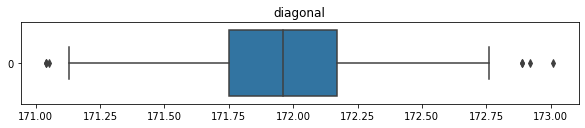

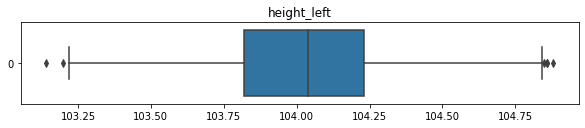

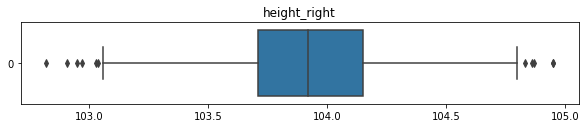

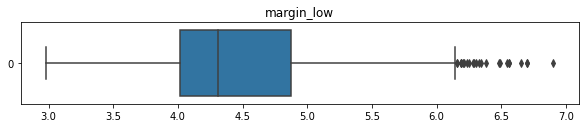

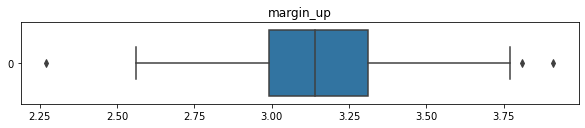

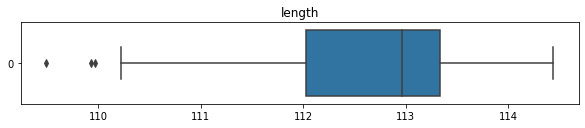

In [146]:
for i in range(1, bil.shape[1]):
    plt.figure(figsize=(10,1.5))    
    plt.title(bil.columns[i])
    sns.boxplot(data = bil[bil.columns[i]], orient = 'h')
    plt.show()

>>> #### Normalité des variables: histogrammes et probplot

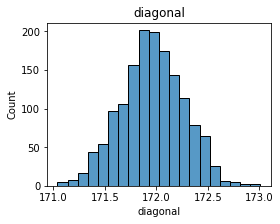

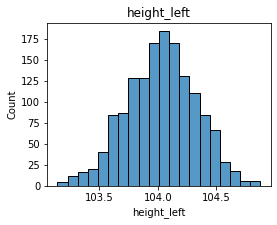

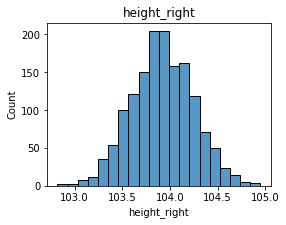

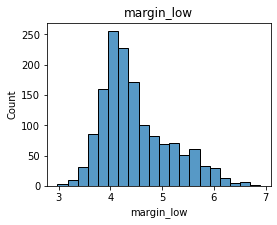

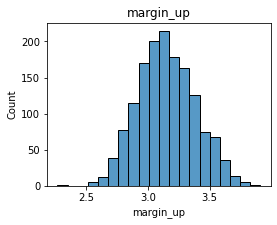

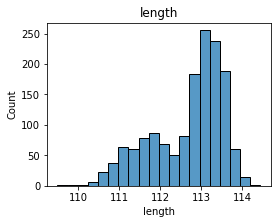

In [147]:
for i in range(1, bil.shape[1]):
    plt.figure(figsize=(4,3))    
    plt.title(bil.columns[i])
    sns.histplot(bil[bil.columns[i]], bins=20)
    plt.show()

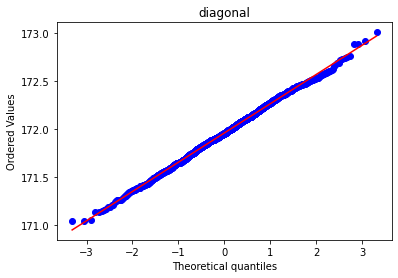

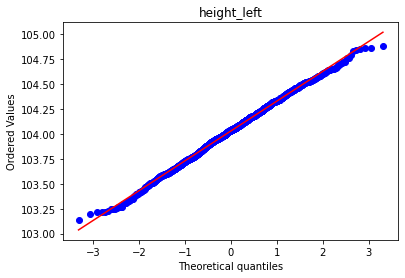

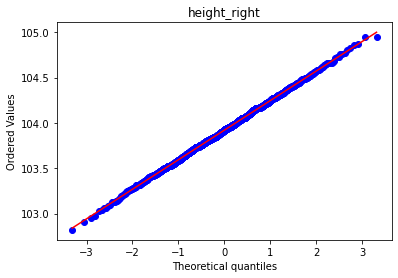

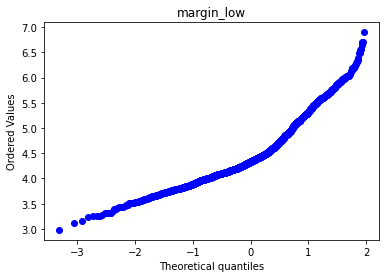

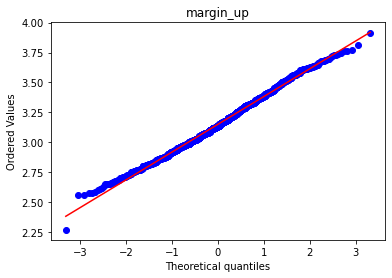

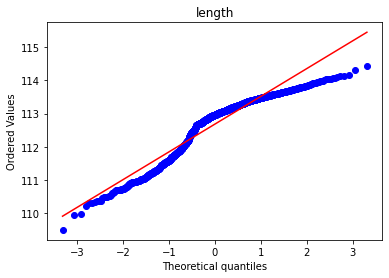

In [148]:
import scipy.stats as stats
for i in range(1, bil.shape[1]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    stats.probplot(bil[bil.columns[i]], dist="norm", plot=ax)
    ax.set_title(bil.columns[i])

>>> ####  Colinéarité des variables: pairplot et matrice de corrélation

In [149]:
#sns.pairplot(bil, hue='is_genuine')

In [150]:
corr_bil = bil.corr()

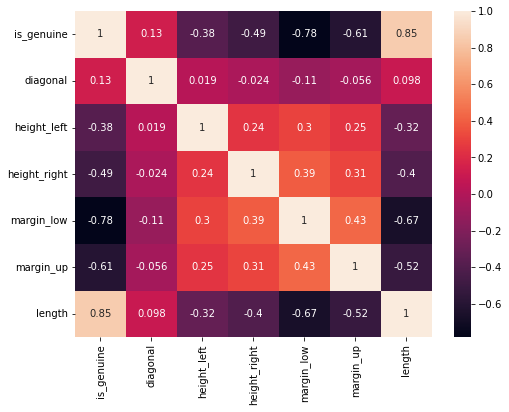

In [151]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_bil, annot=True)
plt.show()

Pas de corrélation > à 0,8 dans les variables qui vont constituer les features du modèle

>>> #### Lien Length / Margin_low: scatterplot:

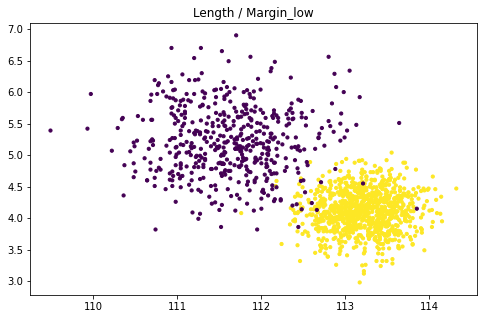

In [152]:
plt.figure(figsize=(8,5))
plt.title('Length / Margin_low')
plt.scatter(bil['length'], bil['margin_low'], c=bil['is_genuine'], s=10)
plt.show()

>>> #### Visualisation False / True par variable: catplots

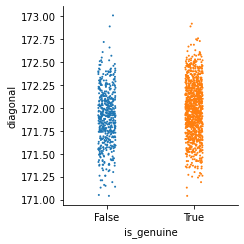

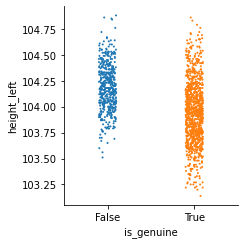

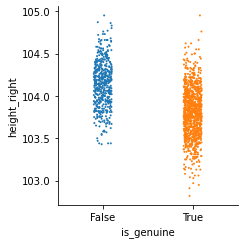

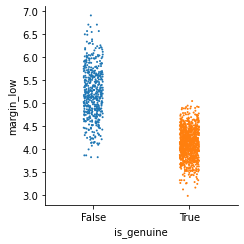

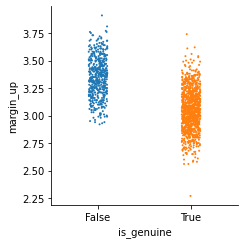

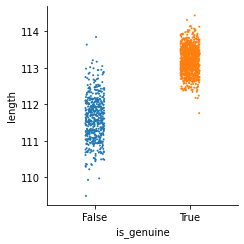

In [153]:
for i in range(1, bil.shape[1]):  
    sns.catplot(x='is_genuine', y=bil.columns[i], data=bil, s=2, height=3.5) #, orient='h')
    plt.show()

<br>

# 3. Nettoyage

> ## Gestion des valeurs manquantes

In [154]:
bil.margin_low.isna().sum()

37

In [155]:
bil_miss = bil[bil.margin_low.isna()]

In [156]:
bil_miss.shape

(37, 7)

In [157]:
bil_no_miss = bil.dropna()
bil_no_miss.shape

(1463, 7)

In [158]:
bil_no_miss.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


>> ### Option 1: éliminer les valeurs manquantes

In [159]:
bil_no_miss.to_csv('bill_dropna.csv', index=False)

<br>

>> ### Option 2: régression linéaire simple

In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

<AxesSubplot:xlabel='length', ylabel='margin_low'>

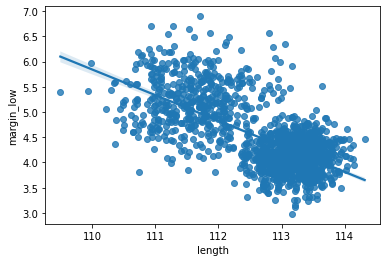

In [161]:
sns.regplot(x = bil['length'], y = bil['margin_low'])

In [162]:
X = bil_no_miss['length']
y = bil_no_miss['margin_low']

In [163]:
X.shape

(1463,)

In [164]:
y.shape

(1463,)

In [165]:
X = X.values.reshape(X.shape[0],1)
y = y.values.reshape(y.shape[0],1)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [167]:
lrs = LinearRegression()

In [168]:
lrs.fit(X_train,y_train)

LinearRegression()

In [169]:
y_pred = lrs.predict(X_test)

In [170]:
r2_score(y_test, y_pred)

0.469322114307938

In [171]:
y_pred_train = lrs.predict(X_train)

In [172]:
r2_score(y_train, y_pred_train)

0.43877892959647924

>> ### Option 3: régression linéaire multiple

In [173]:
X = bil_no_miss.drop(columns=['is_genuine', 'margin_low'], axis=0)
y = bil_no_miss.margin_low

In [174]:
y = y.values.reshape(y.shape[0],1)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

>>> #### Vérification des conditions de la régression

>>>> ##### Significativité des variables:

In [176]:
import statsmodels.formula.api as smf
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length'
                    , data=bil_no_miss).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          2.60e-202
Time:                        19:08:13   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Toutes les variables sont significatives (p-value <0,05).

>>>> ##### Colinéarité des variables (VIF):

In [177]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [178]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i).round(2) 
 for i in np.arange(1,variables.shape[1])]

[1.01, 1.14, 1.23, 1.4, 1.58]

Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

>>> #### Dummy regressor

In [179]:
dummy_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', DummyRegressor(strategy='median'))
     ])
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', DummyRegressor(strategy='median'))])

In [180]:
y_pred = dummy_pipe.predict(X_test)

In [181]:
tr_score = dummy_pipe.score(X_train, y_train).round(4)
te_score = dummy_pipe.score(X_test, y_test).round(4)
print(f"Score train: {tr_score} Score test: {te_score}")

Score train: -0.0733 Score test: -0.0587


>>> #### Régression linéaire

In [182]:
li_reg_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LinearRegression())
])

In [183]:
li_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('model', LinearRegression())])

In [184]:
y_pred = li_reg_pipe.predict(X_test)

>>> #### Score: R²

In [185]:
r2_score(y_test, y_pred).round(4)

0.4943

In [186]:
tr_score = li_reg_pipe.score(X_train, y_train).round(4)
te_score = li_reg_pipe.score(X_test, y_test).round(4)
print(f"Score train: {tr_score} \nScore test: {te_score}")

Score train: 0.4732 
Score test: 0.4943


>>> #### Validation du modèle

In [187]:
residual = (y_test - y_pred)

>>>> ##### Normalité des résidus

<AxesSubplot:ylabel='Count'>

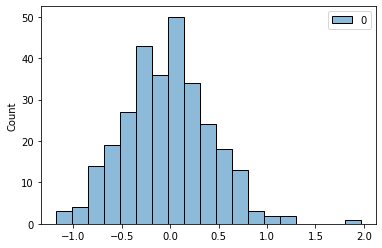

In [188]:
sns.histplot(residual)

Shapiro-Wilk test (normalité):

In [189]:
from scipy.stats import shapiro, anderson

In [190]:
stat, p = shapiro(residual)
p

0.050550688058137894

Anderson-Darling test (normalité):

In [191]:
residual_flat_list = [item for sublist in residual for item in sublist]

In [192]:
statistic, critical_values, levels = anderson(residual_flat_list)
print('Statistic:',statistic.round(3))
print('Critical value:',critical_values)
print('Niveaux:',levels)

Statistic: 0.275
Critical value: [0.568 0.647 0.777 0.906 1.078]
Niveaux: [15.  10.   5.   2.5  1. ]


On ne peut pas rejeter l'hypothèse de normalité (statistic < critical_value quel que soit le niveau)

>>>> ##### Homoscédasticité des résidus:

Text(0.5, 1.0, 'Residual Plot')

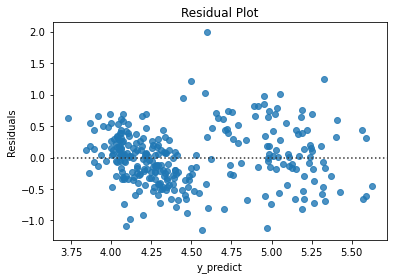

In [193]:
sns.residplot(x=y_pred,y=residual)
plt.xlabel("y_predict")
plt.ylabel("Residuals")
plt.title("Residual Plot")

In [194]:
# import statsmodels.stats.api as sms

In [195]:
#_, pval, __, f_pval = sms.het_breuschpagan(reg_multi.resid, variables)
# print('p value test Breusch Pagan:', pval)

>>> #### Imputation

In [196]:
bil_miss.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [197]:
X = bil_miss.drop(columns=['is_genuine','margin_low'], axis=0)
bil_miss['margin_low'] = li_reg_pipe.predict(X)

C:\Users\steph\AppData\Local\Temp/ipykernel_2652/2873340249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bil_miss['margin_low'] = li_reg_pipe.predict(X)


In [198]:
bil_reg_lin_imp = pd.merge(bil_no_miss, bil_miss, how='outer')
bil_reg_lin_imp

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,172.17,104.49,103.76,5.039427,2.93,111.21
1496,False,172.08,104.15,104.17,4.784075,3.40,112.29
1497,False,171.72,104.46,104.12,5.727991,3.61,110.31
1498,False,172.66,104.33,104.41,5.185120,3.56,111.47


# Création du csv final

In [199]:
bil_reg_lin_imp.to_csv('billets_final.csv', index=False)